# The representation of women in the cinematic industry over the years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from scipy import stats

In [2]:
DATA_PATH = "MovieSummaries"
MOVIE_PATH = DATA_PATH + "/movie.metadata.tsv"
CHARACTER_PATH = DATA_PATH + "/character.metadata.tsv"
CHARACTER_TYPE_PATH = DATA_PATH + "/tvtropes.clusters.txt"

In [3]:
def convert_date(date_string):
    """
    Convert a date string to a pandas datetime object.

    Parameters:
    - date_string (str): The input date string to be converted.

    Returns:
    - pd.Timestamp: A pandas datetime object representing the converted date.

    Raises:
    - ValueError: If the input date string cannot be converted using any of the specified formats.
    """
    try:
        return pd.to_datetime(date_string, format='%Y-%m-%d')
    except ValueError:
        try:
            return pd.to_datetime(date_string, format='%Y-%m')
        except ValueError:
            try:
                return pd.to_datetime(date_string, format='%Y')
            except ValueError:
                return pd.to_datetime(date_string, format='%Y-%m-%d %H:%M:%S.%f')  

---

### GENERAL ANALYSIS

---

### DATA PREPROCESSING

For this analysis, we will use the files movies.metadata and characters.metadata. 

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='left', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate'])
cmu = cmu.drop('DoB', axis=1)
cmu = cmu.drop('ActorName', axis=1)
cmu = cmu.drop('Languages', axis=1)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
274953,52390,/m/0ds33,Armageddon,1998-06-30,553709788.0,150.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/01drsx"": ""Disast...",Max,M,1.93,NaN,35.0,/m/02vbyk6,/m/0h0pktm,/m/0539fx
331636,21633125,/m/05m_byr,Reconstruction,2003-09-26,NaN,90.0,"{""/m/0k6nt"": ""Denmark""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",Alex David,M,NaN,/m/0268_k,30.0,/m/05p04lw,/m/0cgzfdn,/m/027b3hk


In [6]:
# Keep only the rows for which we have the gender of the actor
cmu = cmu.loc[cmu['Gender'].isin(['F', 'M'])].copy(deep=True)

# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
cmu['ReleaseDate'] = cmu['ReleaseDate'].replace('1010-12-02', '2010-12-02')
# Convert the date in the column 'ReleaseDate' into datetime
ReleaseDate_datatime = cmu['ReleaseDate'].apply(convert_date)
# Add a column with the year of release only
cmu['ReleaseYear'] = ReleaseDate_datatime.dt.year.fillna(0).astype(int)
cmu['ReleaseYear'] = cmu['ReleaseYear'].astype('int64')
cmu['ReleaseYear'].replace(0, np.nan, inplace=True)

# Convert the str-like dictionaries to dictionaries
cmu['Countries'] = cmu['Countries'].apply(ast.literal_eval)
cmu['MovieGenre'] = cmu['MovieGenre'].apply(ast.literal_eval)

# Remove outliers for age and replace null or negative values by NaN
cmu['Age'] = cmu['Age'].apply(lambda x: np.nan if x <= 0 else x)

# Keep only movies between 1912 and 2012 to have at least 200 movies per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Drop outliers for height
Q1 = cmu['Height'].quantile(0.25)
Q3 = cmu['Height'].quantile(0.75)
IQR = Q3 - Q1
cmu = cmu[(cmu['Height'] > Q1 - 1.5 * IQR) & (cmu['Height'] < Q3 + 1.5 * IQR)]

# Drop outliers for Runtime
lower, upper = 40, 180
cmu = cmu[(cmu['Runtime'] >= lower) & (cmu['Runtime'] <= upper)]

In [7]:
cmu.sample(4)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
6944,6768793,/m/0gmz8n,Suyamvaram,1999,NaN,129.0,{'/m/03rk0': 'India'},{'/m/01t_vv': 'Comedy-drama'},Indiran,M,1.520,NaN,23.0,/m/02vcwjf,/m/0h9glkc,/m/0gqxyl,1999.0
395253,3377808,/m/098ftq,Dandelion,2004,NaN,94.0,{'/m/09c7w0': 'United States of America'},"{'/m/02l7c8': 'Romance Film', '/m/0fx2s': 'Tra...",NaN,M,1.753,NaN,49.0,/m/0cs8hr2,NaN,/m/0cyp0k,2004.0
326367,1113205,/m/0473rc,Bedazzled,2000-10-19,90383208.0,93.0,"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/06cvj': 'Romantic comedy', '/m/0vgkd': 'B...",Roberto,M,1.880,NaN,31.0,/m/0hhyzq8,/m/0hhyzqc,/m/0d039r,2000.0
226281,13473149,/m/03c6g3r,Singh Is Kinng,2008-08-07,NaN,135.0,"{'/m/0chghy': 'Australia', '/m/03rk0': 'India'}","{'/m/0lsxr': 'Crime Fiction', '/m/03q4nz': 'Wo...",Lakhan Singh,M,1.880,/m/02sch9,35.0,/m/04m815n,/m/0h60hh4,/m/0gxvjg,2008.0


## AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

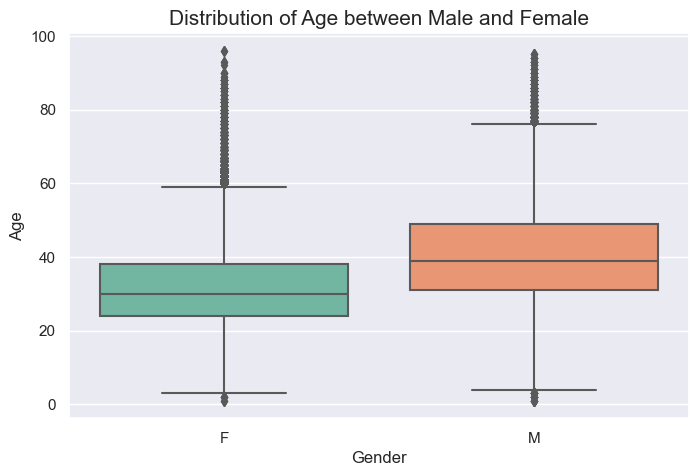

In [8]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [9]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [10]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

TtestResult(statistic=-104.28126043126201, pvalue=0.0, df=124768.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

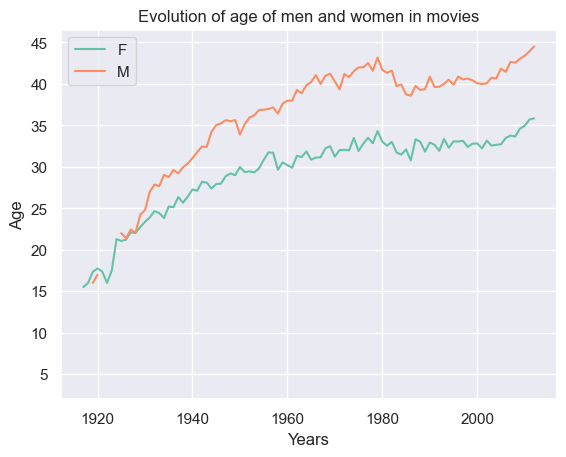

In [16]:
women_mean_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})

plt.plot(women_mean_age_per_year, label='F')
plt.plot(men_mean_age_per_year, label='M')
plt.xlabel('Years')
plt.ylabel('Age')
plt.title('Evolution of age of men and women in movies')
plt.legend()
plt.show()

## What are the types of characters women interpret ? 

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [114]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': chartype}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(lines_new)
chartypes.columns = headers_names
chartypes.head()

,CharType,CharName,MovieName,FreebaseActorMapID,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [115]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [116]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

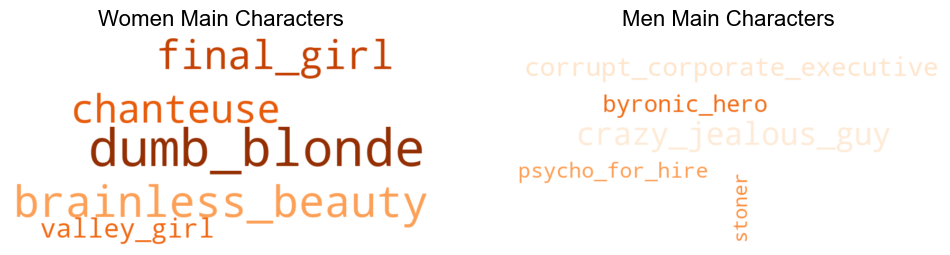

In [117]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Oranges").generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Oranges").generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation="bilinear")
plt.title("Women Main Characters", color="black", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation="bilinear")
plt.title("Men Main Characters", color="black", fontsize=16)
plt.axis("off")

plt.show()